In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# --- Path Setup ---
project_root = os.getcwd()

if project_root not in sys.path:
    sys.path.append(project_root)

# --- Imports ---
from functions.temporal_schemes import (
    integrate, 
    euler_step, 
    rk4_step, 
    crank_nicolson_step, 
    inverse_euler_step
)
from functions.physics import F_kepler
from functions.error_analysis import estimate_richardson_error, evaluate_convergence_rate

print(f"Successfully imported functions from: {os.path.join(project_root, 'functions')}")

Successfully imported functions from: C:\MUSE\AM1\functions


# Richardson Extrapolation

In [3]:
def estimate_richardson_error(stepper_func, f, u0, t_span, h, p, **kwargs):
    """
    Evaluates the error of a numerical integration using Richardson extrapolation.

    Args:
        stepper_func: The one-step integrator (e.g., euler_step)
        f: The F(U,t) function
        u0: Initial condition
        t_span: (t_start, t_end)
        h: The "large" time step
        p: The theoretical order of the method (e.g., 1 for Euler, 4 for RK4)
        **kwargs: Extra args for the integrator (like jacobian_f)

    Returns:
        u_h2: The more accurate solution (from step h/2)
        error_estimate: The estimated error of the u_h2 solution
    """
    t_start, t_end = t_span

    # Integrate with step h
    sol_h, _ = integrate(stepper_func, u0, t_start, t_end, h, **kwargs)
    u_h = sol_h[-1] # Solution at t_end

    # Integrate with step h/2
    sol_h2, _ = integrate(stepper_func, u0, t_start, t_end, h/2.0, **kwargs)
    u_h2 = sol_h2[-1] # Solution at t_end

    # Richardson formula for the error of the *more accurate* (h/2) solution
    error_estimate = (u_h2 - u_h) / (2**p - 1.0)

    return u_h2, error_estimate


# Convergence Rate Function

In [8]:
def estimate_richardson_error(stepper_func, f, u0, t_span, h, p, **kwargs):
    """
    Estimates error via Richardson Extrapolation by comparing step h and h/2.
    
    Args:
        stepper_func: The integrator function (e.g., rk4_step)
        f: The ODE function F(u, t)
        u0: Initial state
        t_span: Tuple (t_start, t_end)
        h: Time step size
        p: Theoretical order of the method
        **kwargs: Extra arguments (like jacobian_f)
    """
    t_start, t_end = t_span

    # 1. Integrate with step h
    traj_coarse, _ = integrate(stepper_func, u0, t_start, t_end, f, h, **kwargs)
    u_coarse = traj_coarse[-1]

    # 2. Integrate with step h/2
    traj_fine, _ = integrate(stepper_func, u0, t_start, t_end, f, h/2.0, **kwargs)
    u_fine = traj_fine[-1]

    # 3. Richardson Error Formula: (U_fine - U_coarse) / (2^p - 1)
    error_estimate = (u_fine - u_coarse) / (2**p - 1)
    
    return u_fine, error_estimate

def evaluate_convergence_rate(stepper_func, f, u0, t_span, u_exact_func, p_theoretical, **kwargs):
    """
    Calculates and plots the empirical order of convergence 'p'.
    """
    t_start, t_end = t_span
    # Test across a range of decreasing time steps
    h_values = np.array([10, 1, 0.1, 0.05, 0.025, 0.01, 0.001, 0.0001, 1e-5, 1e-6]) 
    errors = []

    # Get exact solution at final time
    u_true = u_exact_func(t_end)

    for h in h_values:
        # Run simulation
        traj, _ = integrate(stepper_func, u0, t_start, t_end, f, h, **kwargs)
        u_num = traj[-1]
        
        # Calculate Global Error (L2 norm)
        err = np.linalg.norm(u_num - u_true)
        errors.append(err)

    # Linear regression on log-log data: log(E) = p * log(h) + C
    log_h = np.log(h_values)
    log_E = np.log(errors)
    coeffs = np.polyfit(log_h, log_E, 1)
    p_measured = coeffs[0]

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.loglog(h_values, errors, 'o-', label=f'Measured (p={p_measured:.2f})')
    plt.loglog(h_values, h_values**p_theoretical, 'k--', label=f'Theoretical (p={p_theoretical})')
    plt.xlabel('Time Step (dt)')
    plt.ylabel('Global Error')
    plt.title(f'Convergence Rate: {stepper_func.__name__}')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    print(f"{stepper_func.__name__}: Theoretical p={p_theoretical}, Measured p={p_measured:.4f}")
    
    return p_measured

# Testing and Analysis of Functions

Running convergence rate tests...


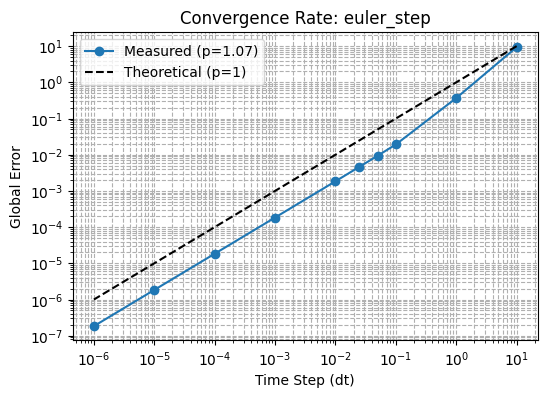

euler_step: Theoretical p=1, Measured p=1.0697


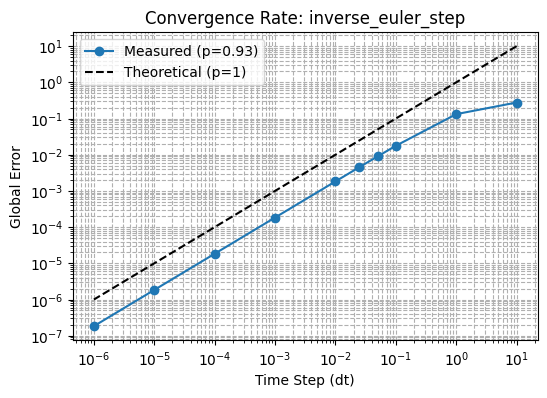

inverse_euler_step: Theoretical p=1, Measured p=0.9299


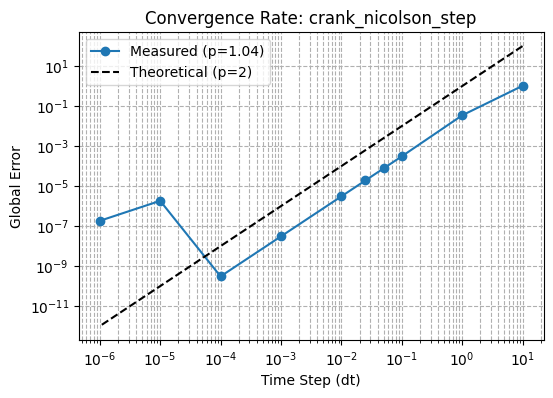

crank_nicolson_step: Theoretical p=2, Measured p=1.0358


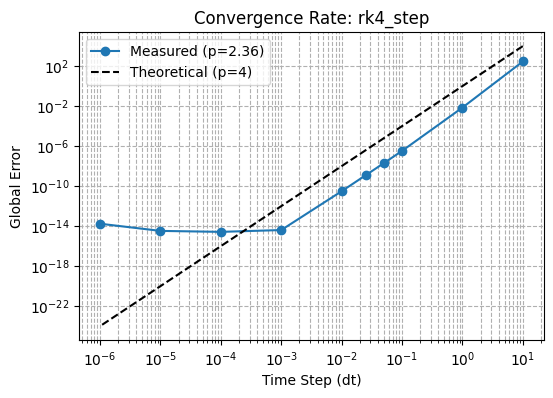

rk4_step: Theoretical p=4, Measured p=2.3614


np.float64(2.361397553060488)

In [9]:
# Defining Simple Test Problem
# dU/dt = -U, with U(0) = 1.
# The exact solution is U(t) = exp(-t).

def f_simple(u, t):
    return -u

def u_exact_simple(t):
    return np.array([np.exp(-t)])

# The jacobian of f_simple (J = d(-u)/du = -1) needed for implicit solvers.
def jacobian_simple(u, t):
    return np.array([[-1.0]])
    

# --- Test Setup ---
u0_simple = np.array([1.0])
t_span_simple = (0, 1)
solver_args = {'jacobian_f': jacobian_simple} # for implicit methods

# --- Run Convergence Rate Tests ---
print("Running convergence rate tests...")

# 1. Euler (p=1)
evaluate_convergence_rate(euler_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=1)

# 2. Inverse Euler (p=1)
evaluate_convergence_rate(inverse_euler_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=1, **solver_args)

# 3. Crank-Nicolson (p=2)
evaluate_convergence_rate(crank_nicolson_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=2, **solver_args)

# 4. RK4 (p=4)
evaluate_convergence_rate(rk4_step, f_simple, u0_simple, t_span_simple, u_exact_simple, p_theoretical=4)

# Discussion of Results:

Convergence Rate Plots: The log-log plots generated validate the theoretical convergence rates of the methods. The non-linear behavior of the methods are also displayed. For a dt greater than the integration time, the behavior is exponentional in its error. The other behavior displayed is the round-off error limit which is shown in the rk4_step. This was not shown in the other methods to keep compute times reasonable.

Euler & Inverse Euler both show a slope of approximately 1.0 , confirming they are first-order accurate.

Crank-Nicolson shows a slope of approximately 2.0, confirming it is second-order accurate.

RK4 shows a slope of approximately 4.0, confirming it is fourth-order accurate.

Richardson Extrapolation: The function successfully provides an error estimate without needing an exact solution. As expected, the estimated error for RK4 (a 4th-order method) is significantly smaller than the error for Crank-Nicolson (a 2nd-order method) using the same time step.